In [198]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Carica il dataset
df = pd.read_csv('only_one_language_country.csv')


C:\Users\BOLO\miniconda3\envs\Business\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 1 center: 49545613.60996457
Cluster 2 center: 782743874.0720575
Cluster 3 center: 3869844026.9244895


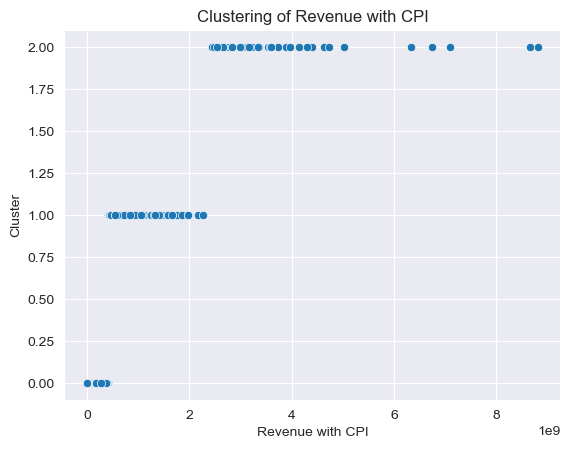

In [195]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
# Definisci il numero di cluster
num_clusters = 3

# Applica il k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['revenue_cluster'] = kmeans.fit_predict(df[['revenue_with_CPI']])

# Esamina i risultati del clustering
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1} center: {center[0]}")

# Visualizza i risultati
sns.scatterplot(data=df, x='revenue_with_CPI', y='revenue_cluster')
plt.xlabel('Revenue with CPI')
plt.ylabel('Cluster')
plt.title('Clustering of Revenue with CPI')
plt.show()


In [199]:
bins = [0, 50000000, 400000000, np.inf]  # Specifica i tuoi bin qui
labels = ['1','2', '3']  # Etichette per i bin
df['revenue_cluster'] = pd.cut(df['revenue_with_CPI'], bins=bins, labels=labels, right=False)


In [196]:
import numpy as np


# Seleziona le colonne rilevanti
columns_to_keep = [
    'genre', 'duration_df1','date_published', 'language', 'country', 'converted_budget',
    'dir_oscar_nomination', 'dir_oscar_won', 'writer_oscar_nomination',
    'BAFTA_nominees','BAFTA_awards',
    'writer_oscar_won', 'cast_oscar_nomination', 'cast_oscar_won',
    'dir_globe_nomination', 'dir_globe_won', 'production_company_df1',
    'cast_globe_nomination', 'cast_globe_won','actors_films_before','director_films_before', 'writers_films_before','revenue_cluster'
]

df_selected = df[columns_to_keep].dropna()
# Visualizza le prime righe del dataset selezionato
print(df_selected.head())

# Funzione per one-hot encoding su colonne con valori multipli separati da virgole
def multi_value_one_hot(df, column):
    s = df[column].str.get_dummies(sep=', ')
    return df.join(s.add_prefix(column + '_'))

# Converti 'date_published' in formato datetime
df_selected['date_published'] = pd.to_datetime(df_selected['date_published'], errors='coerce')

# Estrai il mese dalla colonna 'date_published'
df_selected['month_published'] = df_selected['date_published'].dt.month

# Rimuovi la colonna 'date_published'
df_selected.drop(columns=['date_published'], inplace=True)

# Applica one-hot encoding alle colonne 'genre'
df_selected = multi_value_one_hot(df_selected, 'genre')

# Rimuovi le colonne originali 'genre'
df_selected.drop(columns=['genre'], inplace=True)

X = df_selected.drop('revenue_cluster', axis=1)
y = df_selected['revenue_cluster']
print(X.head())




                 genre  duration_df1 date_published language country  \
0         Crime, Drama          88.0     1913-11-24  English     USA   
1                Drama          59.0     1915-10-31  English     USA   
2  Drama, History, War          77.0     1915-11-14  English     USA   
3                Drama          50.0     1916-04-30  English     USA   
4     Adventure, Crime         300.0     1917-01-19   French  France   

   converted_budget  dir_oscar_nomination  dir_oscar_won  \
0          175700.3                     0              0   
1         3013850.0                     0              0   
2          521727.6                     0              0   
3         5598468.6                     0              0   
4        10802441.1                     0              0   

   writer_oscar_nomination  BAFTA_nominees  ...  cast_oscar_won  \
0                        0               0  ...               0   
1                        0               0  ...               0   
2    

In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definisci le colonne categoriche
categorical_features = ['language', 'country', 'production_company_df1', 'month_published']
categorical_features += [col for col in X.columns if col.startswith('genre_')]

# Trova il numero di campioni della seconda classe più numerosa
class_counts = y_train.value_counts()
second_most_common_count = class_counts.nlargest(2).iloc[-1]

# Applica l'undersampling sulla classe maggioritaria riducendo al numero della seconda classe più numerosa
rus = RandomUnderSampler(sampling_strategy={class_counts.idxmax(): second_most_common_count}, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Applica SMOTENC solo sui dati di training dopo l'undersampling
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train_resampled, y_train_resampled)

print(X_train_resampled.head())

   duration_df1  language  country  converted_budget  dir_oscar_nomination  \
0         133.0  Japanese    Japan         1489542.2                     0   
1          93.0     Other    Other         3750921.0                     0   
2          91.0   English      USA         2615503.2                     0   
3          87.0     Other    Other       162523941.7                     0   
4          90.0    German  Germany         9940243.4                     0   

   dir_oscar_won  writer_oscar_nomination  BAFTA_nominees  BAFTA_awards  \
0              0                        0               1             0   
1              0                        0               0             0   
2              0                        0               0             0   
3              0                        0               0             0   
4              0                        0               0             0   

   writer_oscar_won  ...  genre_Horror  genre_Music  genre_Musical  \
0         

In [166]:
# Applica one-hot encoding alla colonna 'month_published'
X_train_resampled = pd.get_dummies(X_train_resampled, columns=['month_published'], prefix='month')
X_test = pd.get_dummies(X_test, columns=['month_published'], prefix='month')

# Mantieni solo le colonne dei mesi
month_columns = [col for col in X_train_resampled.columns if col.startswith('month_')]
X_train_resampled = X_train_resampled[month_columns + [col for col in X_train_resampled.columns if not col.startswith('month_')]]

month_columns = [col for col in X_test.columns if col.startswith('month_')]
X_test = X_test[month_columns + [col for col in X_test.columns if not col.startswith('month_')]]


# Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
X_train_resampled = multi_value_one_hot(X_train_resampled, 'language')
X_train_resampled = multi_value_one_hot(X_train_resampled, 'country')
X_train_resampled = multi_value_one_hot(X_train_resampled, 'production_company_df1')


X_test = multi_value_one_hot(X_test, 'language')
X_test = multi_value_one_hot(X_test, 'country')
X_test = multi_value_one_hot(X_test, 'production_company_df1')

# Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
X_train_resampled.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)
X_test.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)

# Rimuovi righe con NaN nella colonna 'converted_budget'
#df_selected = df_selected.dropna(subset=['converted_budget'])

# Normalizzazione delle variabili numeriche
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = ['duration_df1', 'converted_budget', 
                     'dir_oscar_nomination', 'dir_oscar_won', 
                     'writer_oscar_nomination', 'writer_oscar_won', 
                     'cast_oscar_nomination', 'cast_oscar_won', 
                     'dir_globe_nomination', 'dir_globe_won', 
                     'cast_globe_nomination', 'cast_globe_won',
                     'BAFTA_nominees','BAFTA_awards',
                     'actors_films_before', 'director_films_before', 'writers_films_before']
X_train_resampled[numerical_columns] = scaler.fit_transform(X_train_resampled[numerical_columns])
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])

X_train_resampled, X_test = X_train_resampled.align(X_test, join='outer', axis=1, fill_value=0)

#X_train_resampled = X_train_resampled[selected_features_mi.to_list()]
#X_test = X_test[selected_features_mi.to_list()]

# Verifichiamo il risultato
print(X_train_resampled.head())

   month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0     True    False    False    False    False    False    False    False   
1    False    False    False    False    False    False    False    False   
2    False    False    False    False    False    False     True    False   
3    False    False    False    False    False    False     True    False   
4    False    False    False    False    False    False    False    False   

   month_9  month_10  ...  production_company_df1_Lionsgate  \
0    False     False  ...                                 0   
1    False     False  ...                                 0   
2    False     False  ...                                 0   
3    False     False  ...                                 0   
4    False      True  ...                                 0   

   production_company_df1_MGM  production_company_df1_Other  \
0                           0                             1   
1                           0   

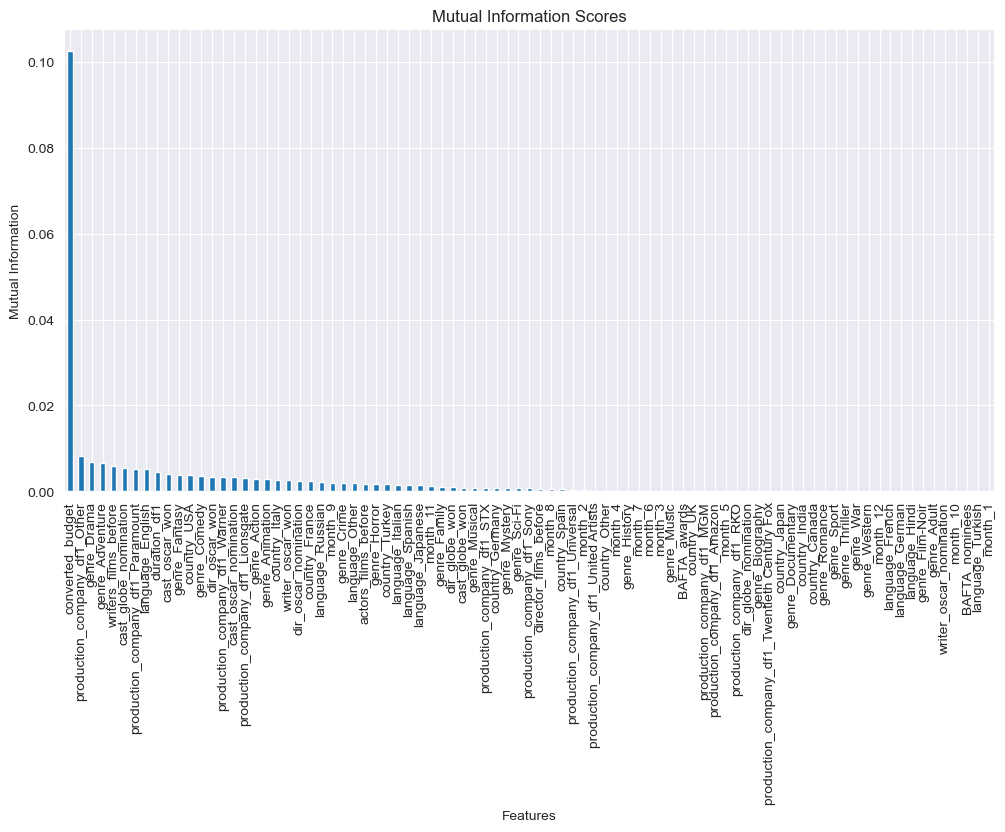

Selected features based on Mutual Information:
Index(['converted_budget', 'production_company_df1_Other', 'genre_Drama',
       'genre_Adventure', 'writers_films_before', 'cast_globe_nomination',
       'production_company_df1_Paramount', 'language_English', 'duration_df1',
       'cast_oscar_won', 'genre_Fantasy', 'country_USA', 'genre_Comedy',
       'dir_oscar_won', 'production_company_df1_Warner',
       'cast_oscar_nomination', 'production_company_df1_Lionsgate',
       'genre_Action', 'genre_Animation', 'country_Italy', 'writer_oscar_won',
       'dir_oscar_nomination', 'country_France', 'language_Russian', 'month_9',
       'genre_Crime', 'language_Other', 'actors_films_before', 'genre_Horror',
       'country_Turkey', 'language_Italian', 'language_Spanish',
       'language_Japanese', 'month_11', 'genre_Family'],
      dtype='object')
   converted_budget  production_company_df1_Other  genre_Drama  \
0         -0.610186                             1            0   
1         -0.

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Applica one-hot encoding alla colonna 'month_published'
X_train = pd.get_dummies(X_train, columns=['month_published'], prefix='month')

# Mantieni solo le colonne dei mesi
month_columns = [col for col in X_train.columns if col.startswith('month_')]
X_train = X_train[month_columns + [col for col in X_train.columns if not col.startswith('month_')]]

# Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
X_train = multi_value_one_hot(X_train, 'language')
X_train = multi_value_one_hot(X_train, 'country')
X_train = multi_value_one_hot(X_train, 'production_company_df1')

# Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
X_train.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)

# Rimuovi righe con NaN nella colonna 'converted_budget'
X_train = X_train.dropna(subset=['converted_budget'])


# Calcola la mutual information tra ogni feature e la variabile target
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

# Crea un DataFrame per visualizzare i punteggi
mi_scores = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

# Traccia un grafico dei punteggi di mutual information
plt.figure(figsize=(12, 6))
mi_scores.plot(kind='bar')
plt.title('Mutual Information Scores')
plt.ylabel('Mutual Information')
plt.xlabel('Features')
plt.show()

# Identifica il punto di taglio (puoi osservare il grafico per trovare un calo significativo)
threshold = 0.001  # Esempio di soglia, puoi modificare in base al grafico

# Seleziona le feature con punteggi di mutual information sopra la soglia
selected_features_mi = mi_scores[mi_scores > threshold].index
print("Selected features based on Mutual Information:")
print(selected_features_mi)


X_train_resampled = X_train_resampled[selected_features_mi.to_list()]
X_test = X_test[selected_features_mi.to_list()]

# Verifica del risultato
print(X_train_resampled.head())

In [168]:

# Addestra il modello Random Forest
rf_classifier = RandomForestClassifier(n_jobs=10, n_estimators=500, max_features=10)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = rf_classifier.predict(X_test)

# Fai previsioni sui dati di train
y_pred_train = rf_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Calcola le metriche di valutazione per il train set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')




Test Set - Accuracy: 0.3469586374695864
Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.33      0.50      3873
           1       0.05      0.61      0.10       228
           2       0.01      0.44      0.03         9

    accuracy                           0.35      4110
   macro avg       0.35      0.46      0.21      4110
weighted avg       0.94      0.35      0.47      4110

Test Set - Confusion Matrix:
[[1284 2392  197]
 [   9  138   81]
 [   0    5    4]]

Train Set - Accuracy: 1.0
Train Set - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       952
           1       1.00      1.00      1.00       952
           2       1.00      1.00      1.00       952

    accuracy                           1.00      2856
   macro avg       1.00      1.00      1.00      2856
weighted avg       1.00      1.00      1.00      2856

Train Set - Confus

In [169]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

adaboost_classifier = AdaBoostClassifier(random_state=42)

# Allena il modello
adaboost_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = adaboost_classifier.predict(X_test)

y_pred_train = adaboost_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)


# Calcola le metriche di valutazione per il test set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')



Test Set - Accuracy: 0.3248175182481752
Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.31      0.47      3873
           1       0.06      0.62      0.11       228
           2       0.01      0.44      0.02         9

    accuracy                           0.32      4110
   macro avg       0.35      0.46      0.20      4110
weighted avg       0.94      0.32      0.45      4110

Test Set - Confusion Matrix:
[[1190 2301  382]
 [   9  141   78]
 [   1    4    4]]

Train Set - Accuracy: 0.7878151260504201
Train Set - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       952
           1       0.66      0.78      0.71       952
           2       0.92      0.77      0.84       952

    accuracy                           0.79      2856
   macro avg       0.80      0.79      0.79      2856
weighted avg       0.80      0.79      0.79      2856

Tra

In [170]:
from sklearn.ensemble import GradientBoostingClassifier

# Definizione del classificatore Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)

# Allena il modello
gradient_boosting_classifier.fit(X_train_resampled, y_train_resampled)

# Fai previsioni sui dati di test
y_pred_test = gradient_boosting_classifier.predict(X_test)
y_pred_train = gradient_boosting_classifier.predict(X_train_resampled)

# Calcola le metriche di valutazione per il test set
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Calcola le metriche di valutazione per il train set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_resampled, y_pred_train)

print(f'Test Set - Accuracy: {accuracy_test}')
print(f'Test Set - Classification Report:\n{report_test}')
print(f'Test Set - Confusion Matrix:\n{conf_matrix_test}')

print(f'\nTrain Set - Accuracy: {accuracy_train}')
print(f'Train Set - Classification Report:\n{report_train}')
print(f'Train Set - Confusion Matrix:\n{conf_matrix_train}')


Test Set - Accuracy: 0.34647201946472017
Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.33      0.50      3873
           1       0.05      0.57      0.10       228
           2       0.01      0.44      0.02         9

    accuracy                           0.35      4110
   macro avg       0.35      0.45      0.21      4110
weighted avg       0.94      0.35      0.48      4110

Test Set - Confusion Matrix:
[[1289 2269  315]
 [   9  131   88]
 [   0    5    4]]

Train Set - Accuracy: 0.9191176470588235
Train Set - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       952
           1       0.89      0.88      0.88       952
           2       0.96      0.99      0.97       952

    accuracy                           0.92      2856
   macro avg       0.92      0.92      0.92      2856
weighted avg       0.92      0.92      0.92      2856

Tr

In [200]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Normalizzazione delle variabili numeriche
from sklearn.preprocessing import StandardScaler


# Definisci la strategia di cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Initialize lists to save the evaluation metrics for each fold
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_roc_auc_scores = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []
test_roc_auc_scores = []


# Definisci le colonne categoriche
categorical_features = ['language', 'country', 'production_company_df1', 'month_published']
categorical_features += [col for col in X.columns if col.startswith('genre_')]

rf_classifier = RandomForestClassifier(n_jobs=10, n_estimators=100, max_features=4)
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)

# Loop attraverso i fold
for train_index, test_index in cv.split(X, y):
    # Dividi i dati in training e test set per il fold corrente
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    

    # Trova il numero di campioni della seconda classe più numerosa
    class_counts = y_train_fold.value_counts()
    second_most_common_count = class_counts.nlargest(2).iloc[-1]

    # Applica l'undersampling sulla classe maggioritaria riducendo al numero della seconda classe più numerosa
    rus = RandomUnderSampler(sampling_strategy={class_counts.idxmax(): second_most_common_count}, random_state=42)
    X_fold_resampled, y_fold_resampled = rus.fit_resample(X_train_fold, y_train_fold)

    # Applica SMOTENC solo sui dati di training dopo l'undersampling
    smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
    X_fold_resampled, y_fold_resampled = smote_nc.fit_resample(X_fold_resampled, y_fold_resampled)

    X_fold_resampled = pd.get_dummies(X_fold_resampled, columns=['month_published'], prefix='month')
    X_test_fold = pd.get_dummies(X_test_fold, columns=['month_published'], prefix='month')

    # Mantieni solo le colonne dei mesi
    month_columns = [col for col in X_fold_resampled.columns if col.startswith('month_')]
    X_fold_resampled = X_fold_resampled[month_columns + [col for col in X_fold_resampled.columns if not col.startswith('month_')]]

    month_columns = [col for col in X_test_fold.columns if col.startswith('month_')]
    X_test_fold = X_test_fold[month_columns + [col for col in X_test_fold.columns if not col.startswith('month_')]]


    # Applica one-hot encoding alle colonne 'genre', 'language', 'country' e 'production_company_df1'
    X_fold_resampled = multi_value_one_hot(X_fold_resampled, 'language')
    X_fold_resampled = multi_value_one_hot(X_fold_resampled, 'country')
    X_fold_resampled = multi_value_one_hot(X_fold_resampled, 'production_company_df1')


    X_test_fold = multi_value_one_hot(X_test_fold, 'language')
    X_test_fold = multi_value_one_hot(X_test_fold, 'country')
    X_test_fold = multi_value_one_hot(X_test_fold, 'production_company_df1')

    # Rimuovi le colonne originali 'genre', 'language', 'country' e 'production_company_df1'
    X_fold_resampled.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)
    X_test_fold.drop(columns=['language', 'country', 'production_company_df1'], inplace=True)

    scaler = StandardScaler()
    numerical_columns = ['duration_df1', 'converted_budget', 
                     'dir_oscar_nomination', 'dir_oscar_won', 
                     'writer_oscar_nomination', 'writer_oscar_won', 
                     'cast_oscar_nomination', 'cast_oscar_won', 
                     'dir_globe_nomination', 'dir_globe_won', 
                     'cast_globe_nomination', 'cast_globe_won',
                     'BAFTA_nominees','BAFTA_awards',
                     'actors_films_before', 'director_films_before', 'writers_films_before']
    
    X_fold_resampled[numerical_columns] = scaler.fit_transform(X_fold_resampled[numerical_columns])
    X_test_fold[numerical_columns] = scaler.fit_transform(X_test_fold[numerical_columns])

    X_fold_resampled, X_test_fold = X_fold_resampled.align(X_test_fold, join='outer', axis=1, fill_value=0)


    # Addestra il modello sui dati di training preprocessati e campionati
    gradient_boosting_classifier.fit(X_fold_resampled, y_fold_resampled)

    

    y_pred_test = gradient_boosting_classifier.predict(X_test_fold)

    y_pred_train = gradient_boosting_classifier.predict(X_fold_resampled)

    test_accuracies.append(accuracy_score(y_test_fold, y_pred_test))
    test_precisions.append(precision_score(y_test_fold, y_pred_test, average='weighted'))
    test_recalls.append(recall_score(y_test_fold, y_pred_test, average='weighted'))
    test_f1_scores.append(f1_score(y_test_fold, y_pred_test, average='weighted'))
    test_roc_auc_scores.append(roc_auc_score(y_test_fold, gradient_boosting_classifier.predict_proba(X_test_fold), multi_class='ovr'))

    # Calculate the evaluation metrics for the training set
    train_accuracies.append(accuracy_score(y_fold_resampled, y_pred_train))
    train_precisions.append(precision_score(y_fold_resampled, y_pred_train, average='weighted'))
    train_recalls.append(recall_score(y_fold_resampled, y_pred_train, average='weighted'))
    train_f1_scores.append(f1_score(y_fold_resampled, y_pred_train, average='weighted'))
    train_roc_auc_scores.append(roc_auc_score(y_fold_resampled, gradient_boosting_classifier.predict_proba(X_fold_resampled), multi_class='ovr'))

    # Print metrics for the current fold
    print(f"Fold {len(test_accuracies)}")
    print(f"Train accuracy: {train_accuracies[-1]}")
    print(f"Train precision: {train_precisions[-1]}")
    print(f"Train recall: {train_recalls[-1]}")
    print(f"Train F1-score: {train_f1_scores[-1]}")
    print(f"Train ROC AUC score: {train_roc_auc_scores[-1]}")
    print(f"Test accuracy: {test_accuracies[-1]}")
    print(f"Test precision: {test_precisions[-1]}")
    print(f"Test recall: {test_recalls[-1]}")
    print(f"Test F1-score: {test_f1_scores[-1]}")
    print(f"Test ROC AUC score: {test_roc_auc_scores[-1]}")
    print()

# Calculate the mean of the evaluation metrics across all folds for the test set
mean_test_accuracy = sum(test_accuracies) / len(test_accuracies)
mean_test_precision = sum(test_precisions) / len(test_precisions)
mean_test_recall = sum(test_recalls) / len(test_recalls)
mean_test_f1_score = sum(test_f1_scores) / len(test_f1_scores)
mean_test_roc_auc_score = sum(test_roc_auc_scores) / len(test_roc_auc_scores)

# Calculate the mean of the evaluation metrics across all folds for the training set
mean_train_accuracy = sum(train_accuracies) / len(train_accuracies)
mean_train_precision = sum(train_precisions) / len(train_precisions)
mean_train_recall = sum(train_recalls) / len(train_recalls)
mean_train_f1_score = sum(train_f1_scores) / len(train_f1_scores)
mean_train_roc_auc_score = sum(train_roc_auc_scores) / len(train_roc_auc_scores)

# Print the mean evaluation metrics
print("Mean training accuracy:", mean_train_accuracy)
print("Mean training precision:", mean_train_precision)
print("Mean training recall:", mean_train_recall)
print("Mean training F1-score:", mean_train_f1_score)
print("Mean training ROC AUC score:", mean_train_roc_auc_score)

print("Mean test accuracy:", mean_test_accuracy)
print("Mean test precision:", mean_test_precision)
print("Mean test recall:", mean_test_recall)
print("Mean test F1-score:", mean_test_f1_score)
print("Mean test ROC AUC score:", mean_test_roc_auc_score)

Fold 1
Train accuracy: 0.916195856873823
Train precision: 0.9159258119671794
Train recall: 0.916195856873823
Train F1-score: 0.9160479143454223
Train ROC AUC score: 0.986075792987919
Test accuracy: 0.10997566909975669
Test precision: 0.9303037045632137
Test recall: 0.10997566909975669
Test F1-score: 0.13442608085496127
Test ROC AUC score: 0.7048181069084506
Fold 2
Train accuracy: 0.9199623352165726
Train precision: 0.9196278228468925
Train recall: 0.9199623352165726
Train F1-score: 0.9197634928025348
Train ROC AUC score: 0.983818388595113
Test accuracy: 0.34647201946472017
Test precision: 0.9392973108373057
Test recall: 0.34647201946472017
Test F1-score: 0.4689673157559575
Test ROC AUC score: 0.7522298648284229
Fold 3
Train accuracy: 0.9234149403640929
Train precision: 0.9231370427193449
Train recall: 0.9234149403640929
Train F1-score: 0.9232607606808745
Train ROC AUC score: 0.9865513315671316
Test accuracy: 0.4408759124087591
Test precision: 0.9421143150109588
Test recall: 0.440875912